In [1]:
import os
import google.generativeai as genai
from gemini_cell_agent.utils import exec_code, streaming_markdown, load_env
from gemini_cell_agent.sys_prompt import pkg_sys_prompt

import datetime

load_env('../.env')
#context_file = genai.upload_file(path='../data/cellpose.txt')
#sys_prompt = pkg_sys_prompt('cellpose')

with open('/Users/cat/demo/sysprompt.txt') as f:
    sys_prompt = f.read()

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model_name = "gemini-1.5-flash"
config = genai.GenerationConfig(temperature=0)

# Create a cache with a 5 minute TTL
# cache = genai.caching.CachedContent.create(
#     model=f'models/{model_name}-001',
#     display_name='cellpose github repo content', # used to identify the cache
#     system_instruction=sys_prompt,
#     contents=[context_file],
#     ttl=datetime.timedelta(minutes=10),
# )

# model = genai.GenerativeModel.from_cached_content(cached_content=cache, generation_config=config)
model = genai.GenerativeModel(model_name, system_instruction=sys_prompt, generation_config=config)

/Users/cat/miniforge3/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Chatbot:
    def __init__(self):
        self.chat_history = []

    def chat(self, user_input):
        input_msg = user_input + f'\n\n Remember for coding tasks, please review the correct and wrong coding examples before generating the code.'
        msg = streaming_markdown(model.start_chat(history=self.chat_history).send_message(input_msg, stream=True))
        self.chat_history.append({"role": "user", "parts": input_msg})
        self.chat_history.append({"role": "model", "parts": msg})
        #print(f"Bot: {msg}")

        while True:
            if "```python" not in msg:
                break
            res = input("Execute code? (y/n): ")
            if res.lower() == 'y':
                code = msg.split("```python")[1].split("```")[0]
                print('Executing the generated code ...')
                captured_output, error_message = exec_code(code)
                print('Code execution done')
                if error_message:
                    print(f"Error: {error_message}")
                    debug_res = input("Debug the code? (y/n): ")
                    if debug_res.lower() == 'y':
                        debug_input = f"Error: {error_message}\n\nType and shape of the vars in the code:\n{captured_output}\n\nCode:\n{code}"
                        msg = streaming_markdown(model.start_chat(history=self.chat_history).send_message(debug_input, stream=True))
                        self.chat_history.append({"role": "user", "parts": debug_input})
                        self.chat_history.append({"role": "model", "parts": msg})
                    else:
                        print("Ok, I won't debug the code.")
                        break
                else:
                    break
            else:
                print("Ok, I won't execute the code.")
                break

In [3]:
chatbot = Chatbot()

In [4]:
chatbot.chat('What is cellpose?')

Cellpose is an open-source, user-friendly Python package designed for image segmentation.  It excels at identifying and segmenting cells and other objects in microscopy images, even those with significant variations in shape, size, and intensity.  Key features include:

- **Robustness:** Cellpose performs well on a wide range of image types and qualities, including noisy or low-resolution images.  It's less sensitive to image artifacts and variations than many other segmentation methods.

- **Speed and Efficiency:** It's computationally efficient, leveraging advanced algorithms to provide fast segmentation, even for large images.

- **Flexibility:** Cellpose offers different model types (e.g., 'cyto' for cytoplasm, 'nuclei' for nuclei) and allows customization of parameters to optimize performance for specific datasets.  It can handle both grayscale and color images.

- **Ease of Use:** The package is designed with a simple and intuitive API, making it accessible to users with varying levels of programming experience.  The `eval()` function is the core of the process, taking an image as input and returning segmentation masks and flow fields.

- **Denoising Capability:** Cellpose includes a built-in denoising model that can improve the quality of noisy images before segmentation.  This is particularly useful for enhancing the accuracy of segmentation in challenging datasets.

In summary, Cellpose provides a powerful and versatile tool for accurate and efficient cell segmentation in various biological imaging applications.  Its ability to handle diverse image types and its user-friendly interface make it a valuable asset for researchers and scientists.


In [5]:
img = '/Users/cat/Downloads/data/general/img0.png'

```python
import numpy as np
from cellpose import models, plot
import matplotlib.pyplot as plt
from skimage.io import imread

# Load the image
img = imread('/Users/cat/Downloads/data/general/img0.png')
if len(img.shape) == 3 and img.shape[-1]<=4:
    img = img[:,:,:3]
diameter = 30  # Adjust if needed based on cell size

# Instantiate the Cellpose model (using CPU)
model = models.Cellpose(gpu=False, model_type='cyto')

# Run cellpose to get masks and flows
masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0, 0])

# Display the segmentation results
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0, 0])
plt.tight_layout()
plt.show()
```


Execute code? (y/n):  y


Executing the generated code ...


/Users/cat/miniforge3/envs/agent/lib/python3.11/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, m

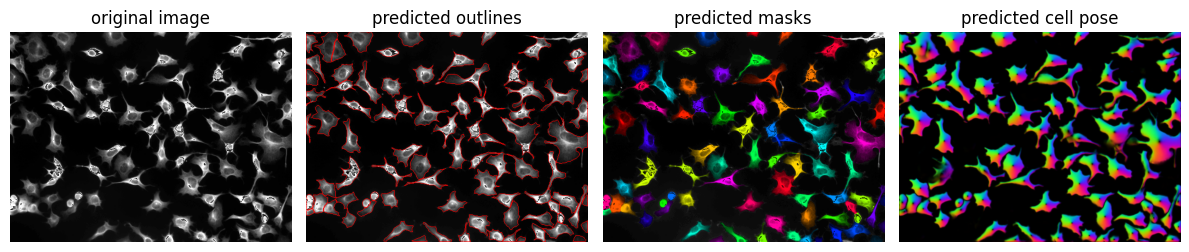

Code execution done
Here is the output:


In [6]:
chatbot.chat('please write code to segment a cell image: '+img)